In [1]:
# Get hidden states by context level and by layer

In [2]:
import os
os.environ['HF_HOME'] = '/sbksvol/amurali/'

from huggingface_hub import login
login(token = "<hf_token>")

import transformers
import torch

import csv
import numpy as np
import pandas as pd

from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForCausalLM, pipeline, LlamaForCausalLM, GenerationConfig

from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
print(f"PyTorch Version: {torch.__version__}")
print(f"Transformers Version: {transformers.__version__}")
print(f"NumPy Version: {np.__version__}")

PyTorch Version: 2.2.2+cu121
Transformers Version: 4.33.3
NumPy Version: 1.26.4


In [4]:
# Load model/create pipeline
model_name = "ivnle/llamatales_jr_8b-lay8-hs512-hd8-33M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True).to("cuda")
# llamatales_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)
# gen_config = GenerationConfig(
#     do_sample=True,
#     top_k=10,
#     max_new_tokens=512,
#     output_hidden_states=True,
#     return_dict_in_generate=True
# )

# Prompts
prompts = {
    1: "Once upon a time there was a boy", 
    2: "Once upon a time there was a poor boy"
}


for prompt_id, prompt_text in prompts.items():
    print(f"Prompt {prompt_id}: \"{prompt_text}\"")
    data = []
    npz_data = {}
    first_npz_data = {}
    # hidden_state_file = f'./hidden_states_2/prompt_{prompt_id}.npz'
    first_hidden_states = f'./hidden_states_2/first_prompt_{prompt_id}.npz'
    for i in tqdm(range(1000)):
        # Generate using pipeline
        # sequences = llamatales_pipeline(
        #     prompt_text,
        #     do_sample=True,
        #     top_k=10,
        #     num_return_sequences=1,
        #     max_new_tokens=100
        # )
        # generated_story = sequences[0]['generated_text']
#         print(f"\nGenerated (pipeline):\n{generated_story}")

        # Count tokens
        # num_tokens_generated_story = len(tokenizer.encode(generated_story))

        # Generate hidden states from model.generate using same prompt
        inputs = tokenizer(prompt_text, return_tensors="pt").to("cuda")
        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            do_sample=True,
            top_k=10,
            num_return_sequences=1,
            max_new_tokens=512,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            return_dict_in_generate=True,
            output_hidden_states=True,
            # use_cache = False
        )

        # outputs = model.generate(
        #     inputs.input_ids,
        #     attention_mask=inputs.attention_mask,
        #     num_return_sequences=1,
        #     eos_token_id=tokenizer.eos_token_id,
        #     pad_token_id=tokenizer.pad_token_id,
        #     generation_config=gen_config
        # )
        
        generated_story = tokenizer.batch_decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
#         print("New Story: \n", new_story)
        
#         print("Length of Generated Story: ", num_tokens_generated_story)
#         print("Length of New Story: ", len(tokenizer.encode(new_story)))
        
        # Map output tokens to prompt ID
        # output_id = [prompt_id] * num_tokens_generated_story

        # Extract hidden states
        convert_hidden_states = []
#         print(f"Type of hidden_states: {type(outputs.hidden_states)}")
        for layer_hidden_states in outputs.hidden_states:
            convert_hidden_states.append([t.detach().cpu().numpy() for t in layer_hidden_states])

        # print(outputs.hidden_states[0][0].shape)

        # for hs in convert_hidden_states:
        #     print(np.linalg.norm(hs))

        # print(f"Hidden states shape: {len(convert_hidden_states)} generated tokens × "
        #       f"{len(convert_hidden_states[1])} layers × "
        #       f"{len(convert_hidden_states[1][0])} sequences × "
        #       f"{len(convert_hidden_states[1][0][0])} tokens × "
        #       f"{len(convert_hidden_states[1][0][0][0])} dims")

        # for n in range(len(convert_hidden_states)):
        #     print(f"{len(convert_hidden_states[n])} layers × "
        #           f"{len(convert_hidden_states[n][0])} sequences × "
        #           f"{len(convert_hidden_states[n][0][0])} tokens × " 
        #           f"{len(convert_hidden_states[n][0][0][0])} dims")

#         print("Num Tokens: ", len(convert_hidden_states[0][0][0])) #same as context (length of original generated story)

        # Save hidden states to file
        # arr = np.empty(len(convert_hidden_states), dtype=object)
        # arr[:] = convert_hidden_states
        # npz_data[f"arr_{i}"] = arr
        # npz_data[f"arr_{i}"] = convert_hidden_states[1:]
        first_npz_data[f"arr_{i}"] = convert_hidden_states[0]
        
        num_tokens_generated_story = len(tokenizer.encode(generated_story))
        
        # Store results
        data.append([prompt_id, prompt_text, generated_story, num_tokens_generated_story])
    
    # np.savez_compressed(hidden_state_file, **npz_data)
    np.savez_compressed(first_hidden_states, **first_npz_data)
    
    df = pd.DataFrame(data, columns=["prompt_id", "prompt", "story", "len_generated_story"])
    if(prompt_id == 1): df.to_csv("story_dataset_2.csv", index = False)
    else:
        df.to_csv('story_dataset_2.csv', mode='a', header = False, index = False)
        


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Prompt 1: "Once upon a time there was a boy"


  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [32:06<00:00,  1.93s/it]


Prompt 2: "Once upon a time there was a poor boy"


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [31:43<00:00,  1.90s/it]


In [5]:
# Load model/create pipeline
model_name = "ivnle/llamatales_jr_8b-lay8-hs512-hd8-33M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True).to("cuda")

# Prompts
prompts = {
    1: "Once upon a time there was a boy",
    2: "Once upon a time there was a poor boy"
}

In [6]:
for prompt in prompts.values():
    print(len(tokenizer.encode(prompt)))

9
10


In [7]:
# for i in range(1000):
#     if(len(npz_data[f"arr_{i}"][0][0][0][0]) != 512):
#         # print(i)
#         print(len(npz_data[f"arr_{i}"]))

In [8]:
# npz_data["arr_1"][0][0].shape

In [9]:
#100x9x1x9x512

In [10]:
df = pd.read_csv("story_dataset_2.csv")
df

,prompt_id,prompt,story,len_generated_story
0,1,Once upon a time there was a boy,Once upon a time there was a boy named Timmy. ...,320
1,1,Once upon a time there was a boy,Once upon a time there was a boy named Timmy. ...,363
2,1,Once upon a time there was a boy,Once upon a time there was a boy named Timmy. ...,244
3,1,Once upon a time there was a boy,Once upon a time there was a boy who loved to ...,304
4,1,Once upon a time there was a boy,Once upon a time there was a boy named Timmy. ...,294
...,...,...,...,...
1995,2,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,287
1996,2,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,306
1997,2,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,318
1998,2,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,297


(array([ 12., 100., 324., 516., 501., 317., 167.,  45.,  12.,   6.]),
 array([157. , 193.5, 230. , 266.5, 303. , 339.5, 376. , 412.5, 449. ,
        485.5, 522. ]),
 <BarContainer object of 10 artists>)

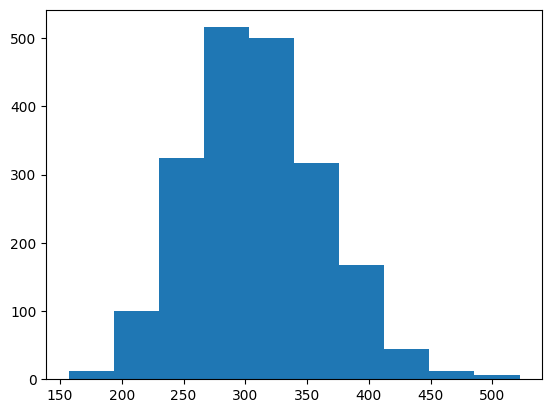

In [14]:
import matplotlib.pyplot as plt

plt.hist(df.len_generated_story)